In [1]:
# Import libraries
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pickle
import os
from glob import glob
from collections import defaultdict

In [2]:
# Load main CSV files
train_df = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train.csv')
wavelengths_df = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv')
train_star_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train_star_info.csv')

In [3]:
# Load main CSV files
train_df = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train.csv')
wavelengths_df = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv')
train_star_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train_star_info.csv')

In [4]:
# Summary stats of flux values (excluding planet_id)
target_cols = [col for col in train_df.columns if col != 'planet_id']
flux_summary = train_df[target_cols].agg(['min', 'max', 'mean', 'std']).T
print("Flux value summary (first 5 wavelengths):")
print(flux_summary.head())

Flux value summary (first 5 wavelengths):
           min       max      mean       std
wl_1  0.003654  0.079797  0.014609  0.010652
wl_2  0.003668  0.077146  0.014588  0.010579
wl_3  0.003668  0.077210  0.014583  0.010574
wl_4  0.003667  0.077020  0.014578  0.010568
wl_5  0.003667  0.076574  0.014573  0.010561


In [5]:
# Count unique stars in star info
if 'planet_id' in train_star_info.columns:
    num_stars = train_star_info.drop(columns='planet_id').drop_duplicates().shape[0]
else:
    num_stars = train_star_info.drop_duplicates().shape[0]
print("Number of unique stars:", num_stars)

Number of unique stars: 1100


In [6]:
# Count AIRS observations per planet by checking parquet files in train folder
obs_counts = defaultdict(int)
train_planets = os.listdir('/kaggle/input/ariel-data-challenge-2025/train')

for pid in train_planets:
    air_obs = glob(f"train/{pid}/AIRS-CH0_signal_*.parquet")
    obs_counts[pid] = len(air_obs)

multi_obs = {pid: count for pid, count in obs_counts.items() if count > 1}
print("Planets with multiple AIRS observations:", len(multi_obs))

Planets with multiple AIRS observations: 0


In [7]:
# Check for missing calibration files per planet and band
missing_calibs = []
expected = {"dark", "dead", "flat", "linear_corr", "read"}

for pid in train_planets:
    for band in ["AIRS-CH0", "FGS1"]:
        calib_path = f"train/{pid}/{band}_calibration"
        if os.path.exists(calib_path):
            calib_files = {os.path.splitext(f)[0] for f in os.listdir(calib_path)}
        else:
            calib_files = set()
        missing = expected - calib_files
        if missing:
            missing_calibs.append((pid, band, missing))

print("Planets missing calibration files:", len(missing_calibs))
if missing_calibs:
    print("Example missing calib:", missing_calibs[0])

Planets missing calibration files: 2200
Example missing calib: ('1253730513', 'AIRS-CH0', {'read', 'dead', 'flat', 'dark', 'linear_corr'})


In [8]:
# Distribution of AIRS observations per planet
obs_distribution = pd.Series(list(obs_counts.values())).value_counts().sort_index()
print("Distribution of AIRS observations per planet:")
print(obs_distribution)

Distribution of AIRS observations per planet:
0    1100
Name: count, dtype: int64


In [9]:
# Check unique planet-star mappings by merging train and star info
merged = pd.merge(train_df[['planet_id']], train_star_info, on='planet_id', how='left')
unique_links = merged.drop_duplicates()
print("Unique planet-star mappings:", unique_links.shape[0])

Unique planet-star mappings: 1100


In [10]:
# Load additional metadata files for reference
train_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/adc_info.csv')
train_labels = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/train.csv', index_col='planet_id')
wavelengths = pd.read_csv('/kaggle/input/ariel-data-challenge-2025/wavelengths.csv')
axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2025/axis_info.parquet')

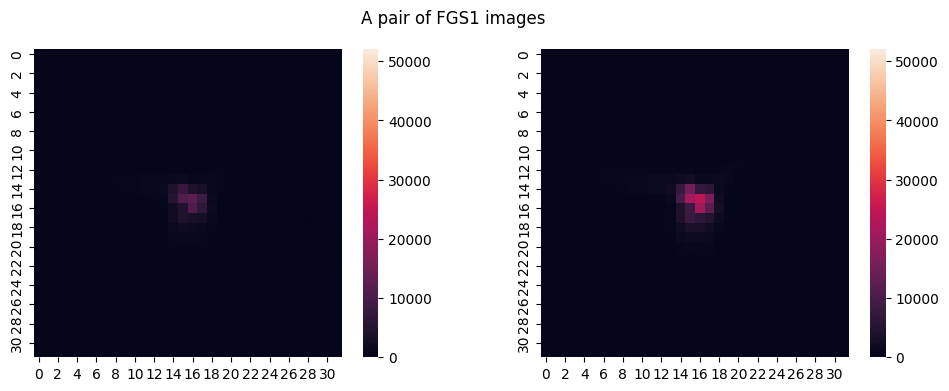

In [11]:
# Plot a pair of FGS1 images for one planet
planet_id = 1010375142
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(f_signal.iloc[0].values.reshape(32, 32), ax=ax1, vmin=0, vmax=52000)
ax1.set_aspect('equal')
sns.heatmap(f_signal.iloc[1].values.reshape(32, 32), ax=ax2, vmin=0, vmax=52000)
ax2.set_aspect('equal')
plt.suptitle('A pair of FGS1 images')
plt.show()

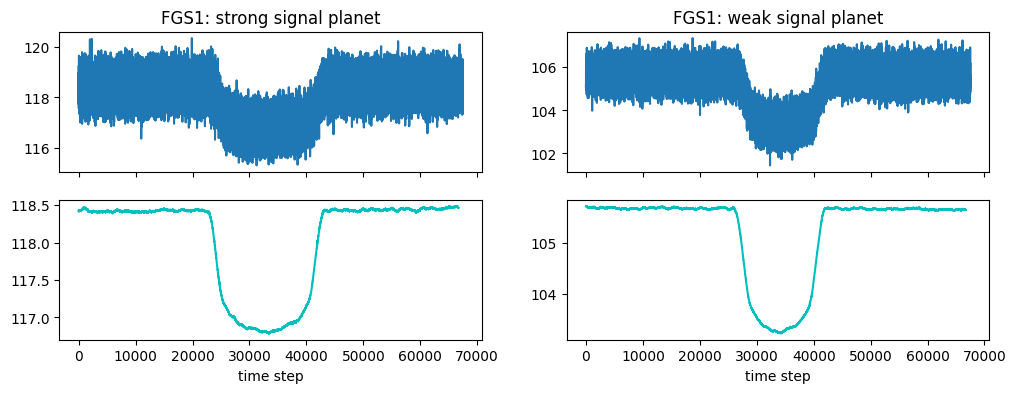

In [12]:
# Plot FGS1 time series for planets with strong and weak signals
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(12, 4))

# Strong signal planet
planet_id = 1048114509
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')
mean_signal = f_signal.values.mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window = 800
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window
ax1.set_title('FGS1: strong signal planet')
ax1.plot(net_signal)
ax3.plot(smooth_signal, color='c')
ax3.set_xlabel('time step')

# Weak signal planet
planet_id = 1240764363
f_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/FGS1_signal_0.parquet')
mean_signal = f_signal.values.mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window
ax2.set_title('FGS1: weak signal planet')
ax2.plot(net_signal)
ax4.plot(smooth_signal, color='c')
ax4.set_xlabel('time step')

plt.show()

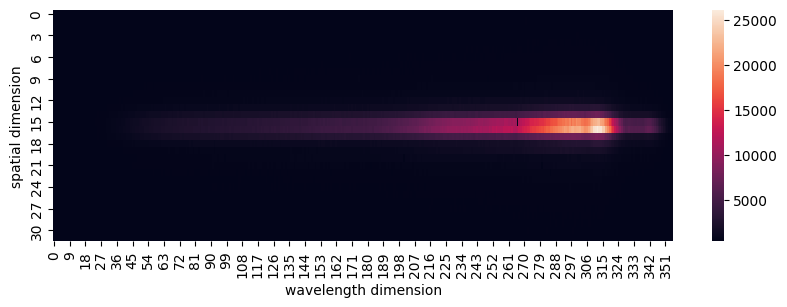

In [13]:
# Plot AIRS-CH0 signal heatmap for one planet
planet_id = 1240764363
a_signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/train/{planet_id}/AIRS-CH0_signal_0.parquet')
a_signal = a_signal.values.reshape(11250, 32, 356)  # reshape to (time, spatial, wavelength)

plt.figure(figsize=(10, 3))
sns.heatmap(a_signal[1])
plt.ylabel('spatial dimension')
plt.xlabel('wavelength dimension')
plt.show()

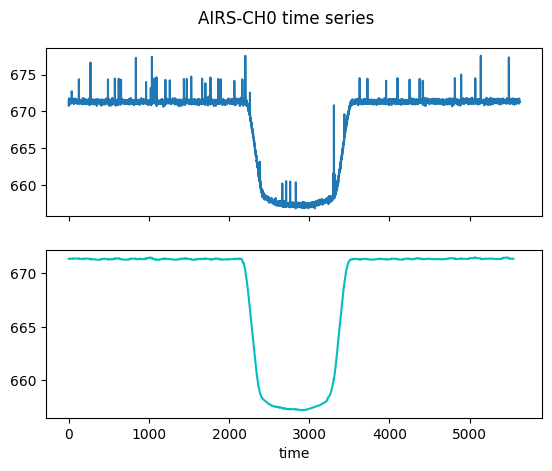

In [14]:
# Plot AIRS-CH0 net signal and smoothened net signal for the same planet
mean_signal = a_signal.mean(axis=2).mean(axis=1)
net_signal = mean_signal[1::2] - mean_signal[0::2]
cum_signal = net_signal.cumsum()
window = 80
smooth_signal = (cum_signal[window:] - cum_signal[:-window]) / window

_, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(net_signal, label='raw net signal')
ax2.plot(smooth_signal, color='c', label='smoothened net signal')
ax2.set_xlabel('time')
plt.suptitle('AIRS-CH0 time series', y=0.96)
plt.show()

In [15]:
# Function to read and preprocess FGS1 signals for multiple planets
def f_read_and_preprocess(dataset, adc_info, planet_ids):
    """
    Read FGS1 parquet signals, compute net signals for all planets.

    Returns:
        numpy array with shape (n_planets, 67500)
    """
    f_raw = np.full((len(planet_ids), 67500), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(enumerate(planet_ids)):
        f_signal = pl.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/{dataset}/{planet_id}/FGS1_signal_0.parquet')
        mean_signal = f_signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / 1024
        net_signal = mean_signal[1::2] - mean_signal[0::2]
        f_raw[i] = net_signal
    return f_raw

In [16]:
# Example: Load and preprocess train FGS1 signals
f_raw_train = f_read_and_preprocess('train', train_adc_info, train_labels.index)

# Save processed data for later reuse
with open('f_raw_train.pickle', 'wb') as f:
    pickle.dump(f_raw_train, f)

1100it [17:17,  1.06it/s]


In [17]:
def a_read_and_preprocess(dataset, adc_info, planet_ids):
    """
    Reads AIRS-CH0 parquet files and extracts net signal time series.
    Returns array of shape (num_planets, 5625) with processed signals.
    """
    # Preallocate array with correct shape
    a_raw_train = np.full((len(planet_ids), 5625), np.nan, dtype=np.float32)
    
    for i, planet_id in tqdm(enumerate(planet_ids), total=len(planet_ids)):
        # Read parquet file for current planet
        a_signal = pl.read_parquet(f'/kaggle/input/ariel-data-challenge-2025/{dataset}/{planet_id}/AIRS-CH0_signal_0.parquet')
        
        # Sum horizontally across spatial dimensions and convert to float
        mean_signal = a_signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / (32*356)
        
        # Calculate net signal by differencing consecutive pairs (length 5625)
        net_signal = mean_signal[1::2] - mean_signal[0::2]
        
        # Assign net_signal to preallocated array row
        a_raw_train[i] = net_signal
    
    return a_raw_train


In [18]:
# Example: Load and preprocess train AIRS-CH0 signals
a_raw_train = a_read_and_preprocess('train', train_adc_info, train_labels.index)

# Save processed AIRS data for later reuse
with open('a_raw_train.pickle', 'wb') as f:
    pickle.dump(a_raw_train, f)

100%|██████████| 1100/1100 [18:21<00:00,  1.00s/it]


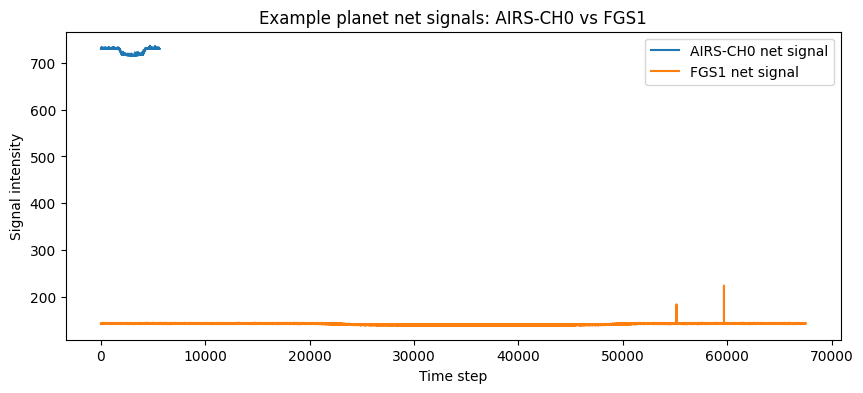

In [19]:
# Plot example AIRS and FGS1 net signals for a planet
planet_idx = 0  # first planet in train_labels
plt.figure(figsize=(10, 4))

plt.plot(a_raw_train[planet_idx], label='AIRS-CH0 net signal')
plt.plot(f_raw_train[planet_idx], label='FGS1 net signal')
plt.legend()
plt.title('Example planet net signals: AIRS-CH0 vs FGS1')
plt.xlabel('Time step')
plt.ylabel('Signal intensity')
plt.show()

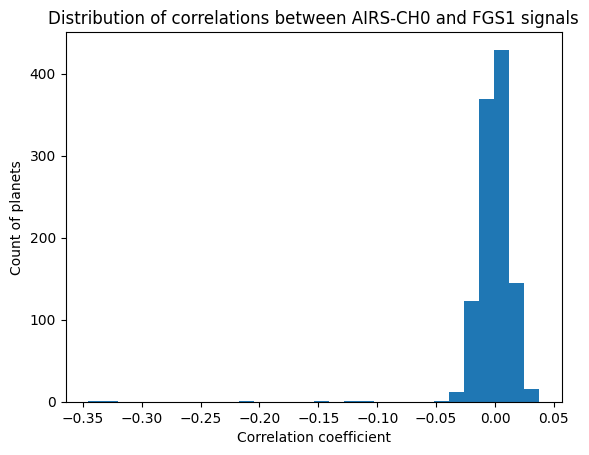

In [20]:
correlations = []
for i in range(len(train_labels)):
    # Find minimum length of the two signals
    length = min(len(a_raw_train[i]), len(f_raw_train[i]))
    
    # Trim both signals to the same length
    a_signal_trimmed = a_raw_train[i][:length]
    f_signal_trimmed = f_raw_train[i][:length]
    
    # Calculate correlation coefficient
    corr = np.corrcoef(a_signal_trimmed, f_signal_trimmed)[0, 1]
    correlations.append(corr)

# Plot the distribution of correlations
plt.hist(correlations, bins=30)
plt.title('Distribution of correlations between AIRS-CH0 and FGS1 signals')
plt.xlabel('Correlation coefficient')
plt.ylabel('Count of planets')
plt.show()

In [21]:
# Print some statistics on the correlations
print("Mean correlation:", np.mean(correlations))
print("Median correlation:", np.median(correlations))
print("Min correlation:", np.min(correlations))
print("Max correlation:", np.max(correlations))

Mean correlation: -0.0011453594668520586
Median correlation: 0.0003393885450009862
Min correlation: -0.34542854305480186
Max correlation: 0.03744979466776438


In [22]:
# Feature engineering function to extract key features from raw signals
def feature_engineering(f_raw, a_raw):
    """
    Extract features capturing relative signal reductions during transit.

    Parameters:
    - f_raw: ndarray, FGS1 net signals (n_planets, 67500)
    - a_raw: ndarray, AIRS-CH0 net signals (n_planets, 33750)

    Returns:
    - DataFrame with two columns: relative reductions for AIRS and FGS1
    """
    # For FGS1: mean signal during obscured period
    obscured_f = f_raw[:, 23500:44000].mean(axis=1)
    # Mean signal during unobscured periods (before and after transit)
    unobscured_f = (f_raw[:, :20500].mean(axis=1) + f_raw[:, 47000:].mean(axis=1)) / 2
    # Calculate relative reduction (transit depth proxy)
    f_relative_reduction = (unobscured_f - obscured_f) / unobscured_f

    # For AIRS-CH0: same logic, adjusted indices for smaller time series
    obscured_a = a_raw[:, 1958:3666].mean(axis=1)
    unobscured_a = (a_raw[:, :1708].mean(axis=1) + a_raw[:, 3916:].mean(axis=1)) / 2
    a_relative_reduction = (unobscured_a - obscured_a) / unobscured_a

    # Build dataframe with features
    df_features = pd.DataFrame({
        'a_relative_reduction': a_relative_reduction,
        'f_relative_reduction': f_relative_reduction
    })

    return df_features

In [23]:
# Generate training features from preprocessed signals
train_features = feature_engineering(f_raw_train, a_raw_train)
print(train_features.head())

# Initialize Ridge regression model with a very small regularization parameter
from sklearn.linear_model import Ridge
model = Ridge(alpha=1e-12)

# Cross-validate with out-of-fold predictions on training data
from sklearn.model_selection import cross_val_predict
oof_predictions = cross_val_predict(model, train_features, train_labels)

   a_relative_reduction  f_relative_reduction
0              0.017189              0.019381
1              0.006461              0.007045
2              0.032780              0.034454
3              0.008676              0.008680
4              0.014173              0.015246


R2 score: 0.882
Root Mean Squared Error (RMSE): 0.003668


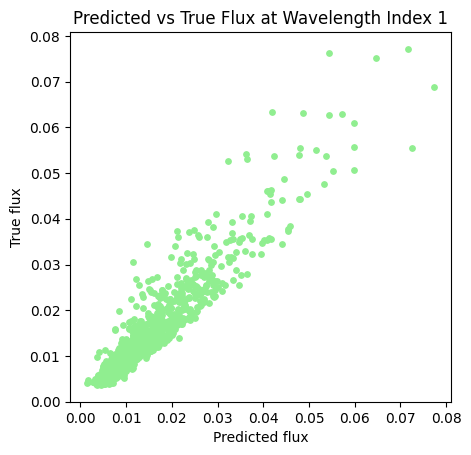

In [24]:
# Evaluate model performance
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(train_labels, oof_predictions)
rmse = mean_squared_error(train_labels, oof_predictions, squared=False)
print(f"R2 score: {r2:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")


# Scatter plot for predictions vs true values for one target (wavelength index 1)
import matplotlib.pyplot as plt

col = 1  # target column index to plot
plt.scatter(oof_predictions[:, col], train_labels.iloc[:, col], s=15, c='lightgreen')
plt.gca().set_aspect('equal')
plt.xlabel('Predicted flux')
plt.ylabel('True flux')
plt.title('Predicted vs True Flux at Wavelength Index 1')
plt.show()

In [25]:
# competition_score.py
# This function computes a Gaussian Log-Likelihood based competition score.

import scipy.stats
import numpy as np
import pandas as pd

# Custom error to show user-friendly message for invalid submissions
class ParticipantVisibleError(Exception):
    pass

def competition_score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    naive_mean: float,
    naive_sigma: float,
    sigma_true: float,
    row_id_column_name='planet_id'
) -> float:
    """
    Calculate the competition score using Gaussian Log Likelihood.
    
    Parameters:
    - solution: true values DataFrame
    - submission: predicted values DataFrame (means + uncertainties)
    - naive_mean: mean of training targets (baseline)
    - naive_sigma: std of training targets (baseline)
    - sigma_true: assumed true measurement noise (small value)
    - row_id_column_name: column to drop for matching
    
    Returns:
    - score: float between 0 and 1 (higher is better)
    """
    # Remove ID column if exists
    solution = solution.drop(columns=[row_id_column_name], errors='ignore')
    submission = submission.drop(columns=[row_id_column_name], errors='ignore')

    # Basic checks
    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission are not allowed.')

    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be numeric.')

    n_wavelengths = len(solution.columns)
    # Submission must have means + sigmas (2x columns)
    if len(submission.columns) != 2 * n_wavelengths:
        raise ParticipantVisibleError('Submission must have twice the number of columns as solution.')

    # Extract predictions and uncertainties
    y_pred = submission.iloc[:, :n_wavelengths].values
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=1e-15, a_max=None)
    y_true = solution.values

    # Calculate Gaussian Log Likelihoods
    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean, scale=naive_sigma))

    # Normalize score to [0,1]
    score = (GLL_pred - GLL_mean) / (GLL_true - GLL_mean)
    return float(np.clip(score, 0.0, 1.0))

In [26]:
# Postprocessing function to prepare submission DataFrame with uncertainties

def postprocessing(pred_array, index, sigma_pred, column_names=None):
    """
    Prepare submission DataFrame combining predicted means and uncertainties.

    Parameters:
    - pred_array: ndarray of predictions (n_samples, n_wavelengths)
    - index: DataFrame index (planet IDs)
    - sigma_pred: float or ndarray of uncertainties (same shape as pred_array)
    - column_names: list of wavelength column names (optional)

    Returns:
    - DataFrame concatenating means and uncertainties side by side
    """
    n_samples, n_waves = pred_array.shape

    if column_names is None:
        column_names = [f"wl_{i+1}" for i in range(n_waves)]

    # If sigma is a scalar, expand it to match pred_array shape
    if np.isscalar(sigma_pred):
        sigma_pred = np.full_like(pred_array, sigma_pred)

    assert sigma_pred.shape == pred_array.shape, "Shape of sigma_pred must match pred_array"

    df_mean = pd.DataFrame(pred_array.clip(0, None), index=index, columns=column_names)
    df_sigma = pd.DataFrame(sigma_pred, index=index, columns=[f"sigma_{i+1}" for i in range(n_waves)])

    return pd.concat([df_mean, df_sigma], axis=1)

In [27]:
# Define sigma_pred (example small uncertainty value; adjust as needed)
sigma_pred = 0.00001  

# Use the postprocessing function on out-of-fold predictions
oof_df = postprocessing(oof_predictions, train_labels.index, sigma_pred)

# Display the first few rows of the postprocessed predictions
display(oof_df.head())

# Compute and print the competition score on the training data with OOF predictions
gll_score = competition_score(
    solution=train_labels.reset_index(),
    submission=oof_df.reset_index(),
    naive_mean=train_labels.values.mean(),
    naive_sigma=train_labels.values.std(),
    sigma_true=0.000003  # assumed small noise level in ground truth
)

print(f"Estimated competition score: {gll_score:.3f}")

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
34983,0.021673,0.020617,0.020616,0.020604,0.020589,0.020573,0.020557,0.020540,0.020525,0.020513,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
1873185,0.008635,0.008472,0.008472,0.008469,0.008467,0.008467,0.008468,0.008470,0.008470,0.008470,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
3849793,0.041463,0.040985,0.040970,0.040948,0.040922,0.040891,0.040855,0.040821,0.040792,0.040767,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
8456603,0.011597,0.011848,0.011844,0.011840,0.011838,0.011837,0.011836,0.011837,0.011837,0.011836,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001
23615382,0.018204,0.017837,0.017833,0.017825,0.017815,0.017805,0.017795,0.017786,0.017777,0.017770,...,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001


Estimated competition score: 0.000
